### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

### Get Data

In [2]:
train = pd.read_hdf('../wip-data/train.h5')
train = train.iloc[:, 1:] # dropping the 'Id' Column
print('The train dataset has %i records and %i features' % (train.shape[0], train.shape[1]))

SalePrice = pd.read_hdf('../wip-data/SalePrice.h5')

The train dataset has 1460 records and 337 features


### Investigating Heteroscedacity

To identify heteroscedacity of the dependent variable, <code>SalePrice</code>, we fit a linear model to the <i>train</i> dataset. We use the resulting model to predict values for the depended variable, <code>SalePrice_hat</code>, calculate the residuals and then plot the studentized residuals versus the values of <code>SalePrice_hat</code>. The shape of the resulting plots are a strong indicator of the presence of heteroscedacity.

#### Fitting a Linear Model

In [3]:
import statsmodels.api as stats

model = stats.OLS(SalePrice, stats.add_constant(train)).fit()
SalePrice_hat = model.predict(stats.add_constant(train))
studentized_residuals = model.get_influence().resid_studentized_internal

/home/sanjeev/anaconda3/envs/Ames/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:693: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


#### Plotting Studentized Residuals versus Predicted Values

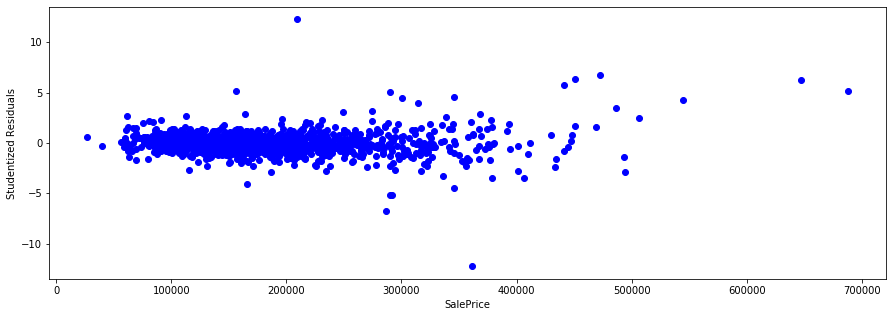

In [4]:
plt.figure(figsize = (15, 5))

plt.scatter(SalePrice_hat, studentized_residuals, color = 'blue')
plt.xlabel('SalePrice')
plt.ylabel('Studentized Residuals')

plt.show()

The plot shows that as the predicted value of the dependent variable, <code>SalePrice_hat</code>, increases so does the variance in the values of the studentized residuals. This is a strong indicator that the train dataset is heteroscedastic.

To eliminate this heteroscedacity, we transform the dependent variable to its log value, fit a linear model to this transformed dependent variable and then check if this transformation helps eliminate the heteroscedacity by plotting the values of the new studentized residuals to the values of the new dependent variable.

#### Transforming <code>SalePrice</code>, Refitting Linear Model

In [5]:
SP_log = np.log(SalePrice)

model = stats.OLS(SP_log, stats.add_constant(train)).fit()
SP_log_hat = model.predict(stats.add_constant(train))
studentized_residuals = model.get_influence().resid_studentized_internal

#### Plotting Studentized Residuals versus Predicted Values

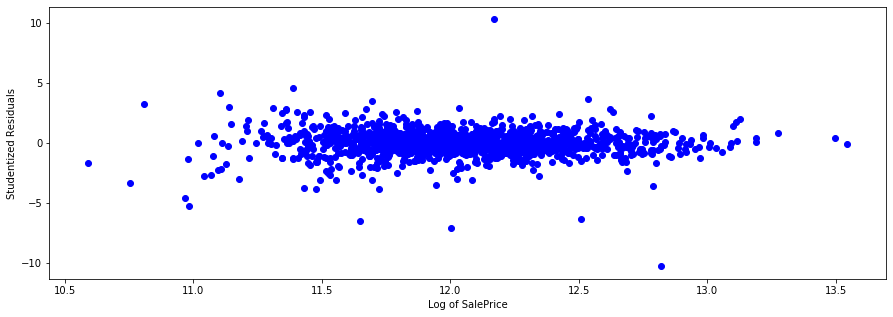

In [6]:
plt.figure(figsize = (15, 5))

plt.scatter(SP_log_hat, studentized_residuals, color = 'blue')
plt.xlabel('Log of SalePrice')
plt.ylabel('Studentized Residuals')

plt.show()

The plot shows that variance in the values of the studentized residuals remains approximately the same (barring a few outliers) over the range of the predicted value of the dependent variable, <code>SP_log_hat</code>. This is a strong indicator we have eliminated heteroscedacity.

We conclude that to build robust linear model we shall use the transformed dependent variable.

### Investigating Likely Non-Linear Response Function

We plot the residuals against the fitted values of the dependent variable and the resultant plot and derive the best fit. The fit will indicate if the response function explaining the dependent variable in terms of the predictors is linear or nonlinear.

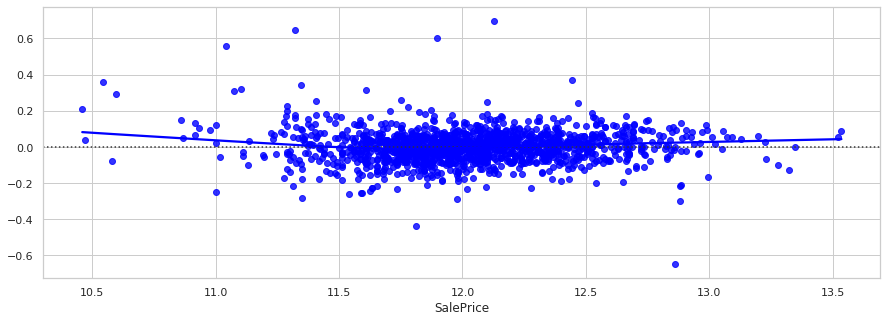

In [7]:
import seaborn as sns

residuals = SP_log_hat - SP_log
plt.figure(figsize = (15, 5))
sns.set(style="whitegrid")
axs = sns.residplot(SP_log, residuals, color = 'blue', lowess = True)

The best fit line is almost a straight line and indicates that the response function is likely to be linear.

### Investigating Outliers and Hi-Leverage Datapoints

<ul>
    <li>Datapoints with studentized residual values greater than 3 are likely to be outliers.
    <li>Datapoints with <i>h-statistic</i> values greater than (p+1)/n, where p is the number of features and n is the number of examples, are likely to be hi-leverage datapoints.
</ul>

Recall that there are 337 (excluding <code>Id</code>) features and 1460 examples in the one-hot encoded <i>train</i> dataset.

In [8]:
outliers_idx = train[studentized_residuals > 3].index.tolist()

h_stat = model.get_influence().hat_matrix_diag
hi_leverage_idx = train[h_stat > ((train.shape[1] + 1)/train.shape[0])].index.tolist()

print('There are %i outliers and %i hi-leverage datapoints' % (len(outliers_idx), len(hi_leverage_idx)))

There are 7 outliers and 345 hi-leverage datapoints


/home/sanjeev/anaconda3/envs/Ames/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


For every datapoint identified as an outlier or hi-leverage, we assess the improvement in the model performance <b>(reduction in 5-fold cross validated root mean squared error)</b> when that particular datapoint is excluded in building the linear model. If the performance improvement is significant then that datapoint becomes a candidate to exclude from the final model.

In [9]:
# Combining the outliers and hi-leverage datapoints in one list and including common elements only once
idx = list(set(outliers_idx + hi_leverage_idx))

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lr_mod = LinearRegression()

# Baseline MSE score with all datapoints included
rmse_base_score = -cross_val_score(lr_mod, train, SP_log, scoring = 'neg_root_mean_squared_error', 
                                   error_score = 'raised').mean()

rmse_score_mat = pd.DataFrame(data = None, columns = ['idx', 'RMSE'])

# MSE scores for models, each model excluding one of the outlier or hi-leverage datapoints
for i in idx:
    rmse_score_ex_i = -cross_val_score(lr_mod, train[~train.index.isin([i])], SP_log[~train.index.isin([i])], 
                                      scoring = 'neg_root_mean_squared_error', error_score = 'raised').mean()
    rmse_score_mat = rmse_score_mat.append({'idx' : i, 'RMSE' : rmse_score_ex_i}, ignore_index = True)
    
rmse_score_mat = rmse_score_mat.astype({'idx' : 'int'})

In [20]:
rmse_base_score

6624504.462848913

We set a threshold of 80% reduction in RMSE to identify outlier and hi-leverage datapoints that may be deleted when building the final models. 

In [10]:
xtrm_idx = [rmse_score_mat.idx[i] for i in range(rmse_score_mat.shape[0]) 
            if (rmse_score_mat.RMSE[i]/rmse_base_score < 0.8)]
print('There are %i datapoints, excluding each of them individually, improves the model RMSE by 20%%.\n' % len(xtrm_idx))

out_idx = [i for i in xtrm_idx if i in outliers_idx]
hi_idx = [i for i in xtrm_idx if i in hi_leverage_idx]
both_idx = [i for i in xtrm_idx if i in out_idx and hi_idx]

print('Of these %i are outliers, %i are hi-leverage and %i are both.' % (len(out_idx), len(hi_idx), len(both_idx)))

There are 38 datapoints, excluding each of them individually, improves the model RMSE by 20%.

Of these 0 are outliers, 38 are hi-leverage and 0 are both.


### Investigating <i>Bias - Variance</i> Tradeoff

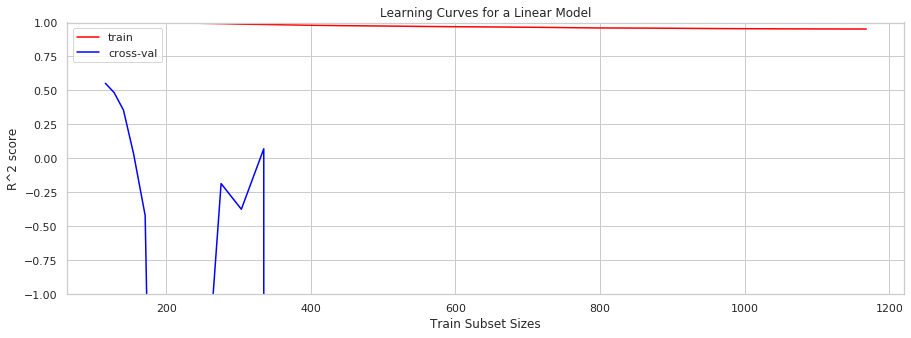

In [11]:
from sklearn.model_selection import train_test_split, learning_curve

train_sizes, train_scores, val_scores = learning_curve(LinearRegression(), train, SP_log, 
                                                       train_sizes = np.logspace(-1, 0, 25), shuffle = True, 
                                                       random_state = 1970, scoring = 'r2')

plt.figure(figsize = (15, 5))

plt.plot(train_sizes, train_scores.mean(axis = 1), color = 'red', label = 'train')
plt.plot(train_sizes, val_scores.mean(axis = 1), color = 'blue', label = 'cross-val')
plt.legend()
plt.xlabel('Train Subset Sizes')
plt.ylabel('R^2 score')
plt.ylim((-1, 1))
plt.title('Learning Curves for a Linear Model')

plt.show()

The learning curves are nowhere close to approaching each other and we can safely conclude that the results of a linear fit are likely to suffer from a variance problem rather than a bias problem. A <b>penalized</b> linear model is therefore likely to deliver better results than a non-penalized model.

### Insights

From the analysis above, we conclude, when building a linear model:
<ol>
    <li>To eliminate the heteroscadacity in the <i>train</i> dataset, we log transform the dependent variable <code>SalePrice</code>.
    <li>The transformed dependent variable is likely well explained as a linear function of the independent variables.
    <li>There are a few datapoints in the <i>train</i> dataset that are hi-leverage datapoints and perhaps may be excluded when building the final model.
    <li>A penalized model is likely to be a better model than an OLS regression model.

### Predictions
<ol>
    <li>We build Lasso and Ridge regression models. For each type of model, we choose the value for the regularization penalty (alpha) that delivers the lowest 5-fold cross-validated RMSE on the <i>train</i> dataset.
    <li>In building these models, we build two sets of models, one that exclude the high-leverage datapoints identified earlier and the other that includes all the datapoints.
    <li>We use the model with the lowest RMSE to make predictions for the <i>test</i> dataset.

In [27]:
# Models excluding the high-leverage datapoints

X = train[~train.index.isin(xtrm_idx)]
y = SP_log[~train.index.isin(xtrm_idx)]

from sklearn.linear_model import LassoCV, RidgeCV

lasso_mod_1 = LassoCV(random_state = 1970).fit(X, y)
y_hat = lasso_mod_1.predict(X)
RMSE = round((np.sum((y_hat - y)**2)/len(y_hat))**0.5, 5)
print('%f is the regularisation penalty for the best fit Lasso linear model' % lasso_mod_1.alpha_)
print('For the best fit Lasso Regression model, the estimated cross validated RMSE = %f\n' % RMSE)

ridge_mod_1 = RidgeCV(scoring = 'neg_root_mean_squared_error').fit(X, y)
y_hat = ridge_mod_1.predict(X)
RMSE = round((np.sum((y_hat - y)**2)/len(y_hat))**0.5, 5)
print('%f is the regularisation penalty for the best fit Ridge linear model' % ridge_mod_1.alpha_)
print('For the best fit Ridge Regression model, the estimated cross validated RMSE = %f' % RMSE)

0.006909 is the regularisation penalty for the best fit Lasso linear model
For the best fit Lasso Regression model, the estimated cross validated RMSE = 0.156750

10.000000 is the regularisation penalty for the best fit Ridge linear model
For the best fit Ridge Regression model, the estimated cross validated RMSE = 0.101460


In [30]:
# Models with all datapoints

X = train
y = SP_log

lasso_mod_2 = LassoCV(random_state = 1970).fit(X, y)
y_hat = lasso_mod_2.predict(X)
RMSE = round((np.sum((y_hat - y)**2)/len(y_hat))**0.5, 5)
print('%f is the regularisation penalty for the best fit Lasso linear model' % lasso_mod_2.alpha_)
print('For the best fit Lasso Regression model, the estimated cross validated RMSE = %f\n' % RMSE)

ridge_mod_2 = RidgeCV(scoring = 'neg_root_mean_squared_error').fit(X, y)
y_hat = ridge_mod_2.predict(X)
RMSE = round((np.sum((y_hat - y)**2)/len(y_hat))**0.5, 5)
print('%f is the regularisation penalty for the best fit Ridge linear model' % ridge_mod_2.alpha_)
print('For the best fit Ridge Regression model, the estimated cross validated RMSE = %f' % RMSE)

0.007092 is the regularisation penalty for the best fit Lasso linear model
For the best fit Lasso Regression model, the estimated cross validated RMSE = 0.169310

10.000000 is the regularisation penalty for the best fit Ridge linear model
For the best fit Ridge Regression model, the estimated cross validated RMSE = 0.109960


<ul>
    <li> The Ridge Regression model outperforms the Lasso Regression model in both sets.
    <li> The model performace improves by less than 10% when the high-leverage datapoints are excluded. This is not a significant improvement and we would rather keep all the <i>train</i> dataset records than exclude any.

In [35]:
test = pd.read_hdf('../wip-data/test.h5')
test_ID = test.Id
test = test.iloc[:, 1:] # dropping the 'Id' Column

y_hat = ridge_mod_2.predict(test)

out = pd.DataFrame({'Id' : test_ID, 'SalePrice' : np.exp(y_hat)})
out.to_csv('../../data/out_ridge.csv', index = False)